For one given image, what is the behavior of the nnInteractive model ? Where does it zoom ? 

In [1]:
import matplotlib
matplotlib.use('inline')
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
%load_ext autoreload
%autoreload 2


import os 
from src.config import config

Loaded configuration for machine: nora


In [3]:
import pandas as pd
nninteractivemetrics_df = pd.read_csv(os.path.join(config["RESULTS_DIR"], "nninteractive_metrics_combined.csv"))
worst_cases = nninteractivemetrics_df.sort_values(by="DSC_AUC", ascending= True)
final_metrics = ['DSC_AUC', 'NSD_AUC', 'DSC_Final', 'NSD_Final', 'TotalRunningTime']
worst_cases[["CaseName",] + final_metrics].head(10)


,CaseName,DSC_AUC,NSD_AUC,DSC_Final,NSD_Final,TotalRunningTime
17,CT_AbdTumor_colon_108.npz,0.319443,0.000000,0.156602,0.000000,45.573677
1014,Microscopy_SELMA3D_patchvolume_nuclei_004.npz,0.380071,0.000000,0.084072,0.000000,333.698785
821,CT_Aorta_AortaK12.npz,0.751685,0.137001,0.315933,0.102656,40.136574
447,MR_BraTS-T2w_bratsgli_0820.npz,0.865819,0.832717,0.304075,0.403349,39.038683
153,MR_BraTS-T2f_bratsgli_0376.npz,0.896423,1.228524,0.489202,0.551198,40.386300
756,MR_Spider_23_t2_spi.npz,0.922077,1.197402,0.407199,0.621050,43.182146
931,MR_BraTS-T2f_bratsgli_0366.npz,1.034267,0.970980,0.344673,0.372844,35.646827
726,MR_BraTS-T2w_bratsgli_1204.npz,1.045128,1.038390,0.424927,0.505481,36.619046
940,MR_BraTS-T2f_bratsgli_1124.npz,1.066388,1.509342,0.263482,0.121582,35.723227
1857,MR_BraTS-T2f_bratsgli_0339.npz,1.068141,1.394876,0.453599,0.642721,39.630353


In [4]:
img_dir = os.path.join(config["DATA_DIR"], "3D_val_npz")
gts_dir = os.path.join(config["DATA_DIR"], "3D_val_gt_interactive_seg")

cases = sorted([f for f in os.listdir(img_dir) if f.endswith(".npz")])

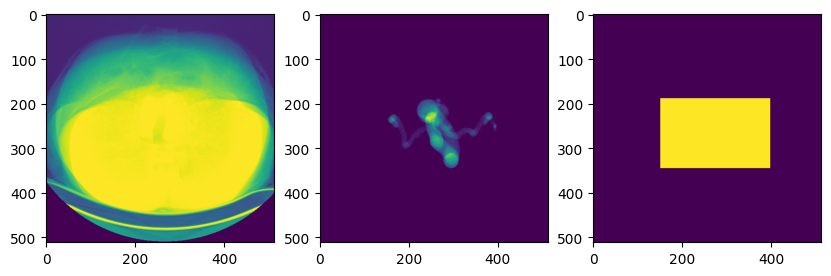

In [5]:

import numpy as np
case_filename = "CT_Aorta_AortaK12"

img_filepath = os.path.join(img_dir, case_filename + ".npz")
gt_filepath = os.path.join(gts_dir, case_filename + ".npz")
img = np.load(img_filepath, allow_pickle=True)["imgs"]
gt = np.load(gt_filepath)["gts"]

# create a bbox from the gt
gt_is_1 = np.where(gt==1)
bbox = (np.min(gt_is_1, axis = 1),np.max(gt_is_1, axis = 1))
bbox = np.array(bbox).T
bbox_channel = np.zeros_like(gt)
bbox_channel[bbox[0][0]:bbox[0][1], bbox[1][0]:bbox[1][1], bbox[2][0]:bbox[2][1]] = 1


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))
ax1.imshow(img.mean(axis=0))
ax2.imshow(gt.mean(axis=0))
ax3.imshow(bbox_channel.mean(axis=0))


In [6]:
import torch
from huggingface_hub import snapshot_download  # Install huggingface_hub if not already installed

from nnInteractive.inference.inference_session import nnInteractiveInferenceSession
#from nnInteractive_fork.inference.inference_session import nnInteractiveInferenceSession
REPO_ID = "nnInteractive/nnInteractive"
MODEL_NAME = "nnInteractive_v1.0"  # Updated models may be available in the future
DOWNLOAD_DIR = "/nfs/norasys/notebooks/camaret/model_checkpoints/nnint"  # Specify the download directory

# RESET MATPLOTLIB BACKEND
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend first
import matplotlib.pyplot as plt
matplotlib.use('inline')  # Switch back to inline for Jupyter
%matplotlib inline

nnUNet_raw is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
nnUNet_results is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [7]:
session = nnInteractiveInferenceSession(
    device=torch.device("cuda:0"),  # Set inference device
    use_torch_compile=False,  # Experimental: Not tested yet
    verbose=False,
    torch_n_threads=os.cpu_count(),  # Use available CPU cores
    do_autozoom=True,  # Enables AutoZoom for better patching
    use_pinned_memory=True,  # Optimizes GPU memory transfers
)

model_path = os.path.join(DOWNLOAD_DIR, MODEL_NAME)
session.initialize_from_trained_model_folder(model_path)

In [8]:
# add batch dimension 
img_batched = img[None]
session.set_image(img_batched)

# --- Define Output Buffer ---
target_tensor = torch.zeros(img_batched.shape[1:], dtype=torch.uint8)  # Must be 3D (x, y, z)
session.set_target_buffer(target_tensor)

In [9]:
session.add_bbox_interaction(bbox, include_interaction=True)


Added new bbox interaction: center 1.6197916666666667, scale [[69, 268, 274]]
Took 0.49 s for initial prediction at zoom out factor 1.6197916666666667
AutoZoom zoom out factor 1.6197916666666667
Zoom out took 0.347 s, max zoom out factor 2.4296875
Took 1.904 s for refining the segmentation with 10 bounding boxes
Done. Total time 2.799s


In [10]:
results = session.target_buffer.clone()

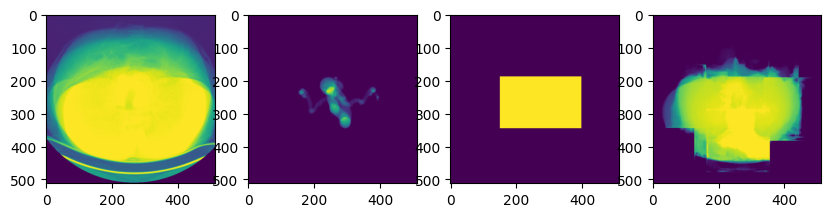

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 4))
ax1.imshow(img.mean(axis=0))
ax2.imshow(gt.mean(axis=0))
ax3.imshow(bbox_channel.mean(axis=0))
ax4.imshow(results.float().mean(axis=0))


In [12]:
session.refinement_bboxes

[[[-27, 165], [198, 390], [155, 347]],
 [[-27, 165], [128, 320], [249, 441]],
 [[-27, 165], [128, 320], [61, 253]],
 [[-27, 165], [268, 460], [249, 441]],
 [[7, 199], [268, 460], [61, 253]],
 [[tensor(-30, device='cuda:0'), tensor(162, device='cuda:0')],
  [tensor(99, device='cuda:0'), tensor(291, device='cuda:0')],
  [tensor(160, device='cuda:0'), tensor(352, device='cuda:0')]],
 [[tensor(-87, device='cuda:0'), tensor(105, device='cuda:0')],
  [tensor(286, device='cuda:0'), tensor(478, device='cuda:0')],
  [tensor(125, device='cuda:0'), tensor(317, device='cuda:0')]],
 [[tensor(-43, device='cuda:0'), tensor(149, device='cuda:0')],
  [tensor(192, device='cuda:0'), tensor(384, device='cuda:0')],
  [tensor(336, device='cuda:0'), tensor(528, device='cuda:0')]],
 [[tensor(-47, device='cuda:0'), tensor(145, device='cuda:0')],
  [tensor(153, device='cuda:0'), tensor(345, device='cuda:0')],
  [tensor(-31, device='cuda:0'), tensor(161, device='cuda:0')]],
 [[tensor(0, device='cuda:0'), tensor(

In [14]:
results.shape

torch.Size([139, 512, 512])